# Lab 6.1: Intro to Convolutions

This lab will focus on performing convolutions, but without training a model.

The purpose is to ensure that we understand what convolutions do to images.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [3]:
import tensorflow as tf

# Convolutional layer

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
# convert color into grayscale by taking average of RGB colors per pixel along axis 2
# https://stackoverflow.com/questions/40700501/how-to-calculate-mean-color-of-image-in-numpy-array
# https://stackoverflow.com/questions/15819980/calculate-mean-across-dimension-in-a-2d-array
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

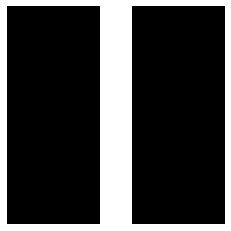

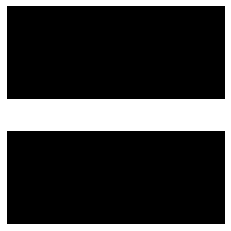

In [5]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [6]:
# changed use_cudnn_on_gpu=False to use_cudnn_on_gpu=True, else it gives error.

In [7]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=True)

In [8]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

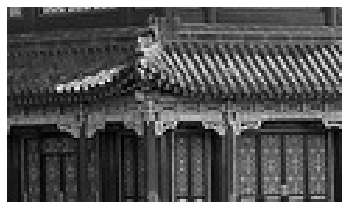

In [9]:
plot_image(images[0, :, :, 0])
plt.show()

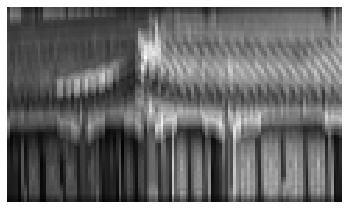

In [10]:
plot_image(output[0, :, :, 0])
plt.show()

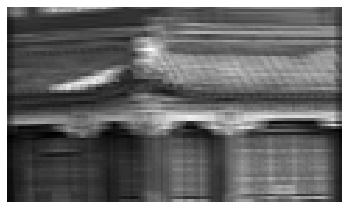

In [11]:
plot_image(output[0, :, :, 1])
plt.show()

## Simple example

In [12]:
#the following code loads two images one Chinese temple and one flower.
#Then it creates two 7x7 filters one with vertical white line in middle and one with horizontal white line in middle.
#It applies these filters to the two images.

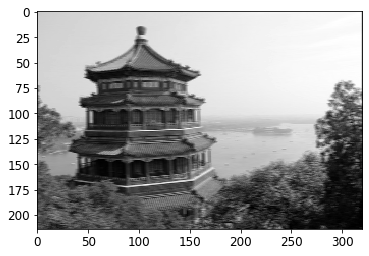

In [13]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map (horizontal filter on 1st image)
plt.show()

In [14]:
#Print the output of vertical filters and horizontal filters respectively.

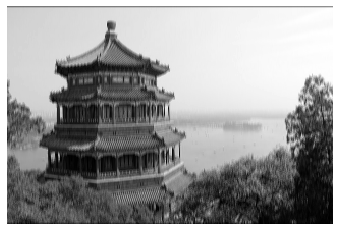

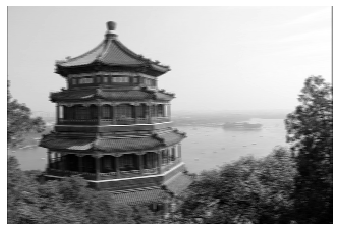

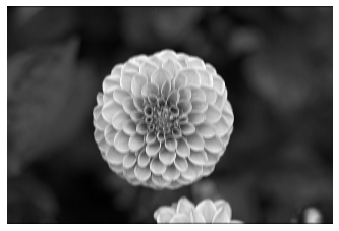

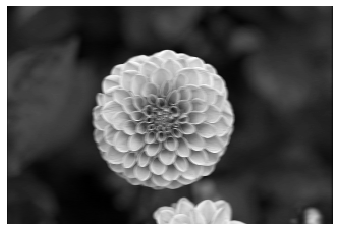

In [15]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

In [16]:
#Let's try using higher level tf.layers API

Using `tf.layers.conv2d()`:

In [17]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.


In [18]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

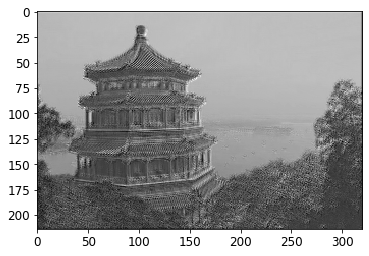

In [19]:
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map (horizontal filter on 1st image)
plt.show()

## VALID vs SAME padding

In [20]:
#lets take a sequence of nos 1 to 13 (inclusive). Apply a prime number filter of all numbers in this range.
#Check impact of applying filter for VALID or SAME padding.

In [21]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


In [22]:
#visualize the effect of multiplying by filter of size 1x6 with and without SAME padding

In [23]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))


VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


# Pooling layer

In [24]:
#The following code creates a max pooling layer using a 2 × 2 kernel, stride 2, and no padding,
#then applies it to all the images in the dataset:

In [25]:
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

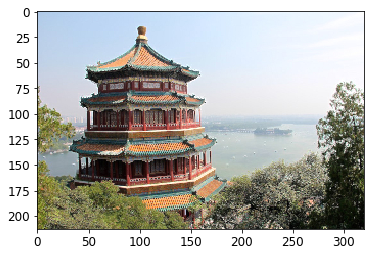

In [26]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
#we can similarly plot output for the second image output[1]
plt.show()

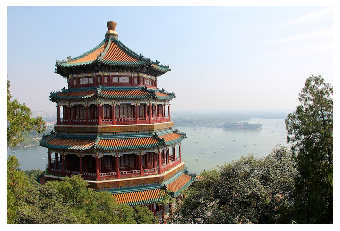

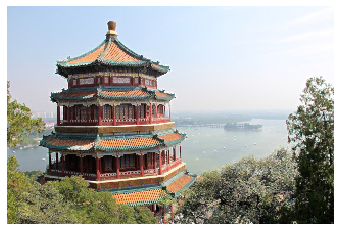

In [27]:
plot_color_image(dataset[0])
plt.show()
    
plot_color_image(output[0])
plt.show()